In [1]:
# libraries we need
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.transforms import v2
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

In [2]:
#An essential feauture of pytorch is its ability to utlize GPUs and TPUs
#This portion of the code chooses the device that while be used,
#if there is a GPU that uses the CUDA toolkit, then it will utlize it
#if not it will use the CPU for calculations
#Note many times, GPUs are much faster option, and allow for more realistic training times

if torch.cuda.is_available(): # Checks if CUDA is availiable, loads the device for computation to the GPU
    device = torch.device('cuda:0')
    print('Running on GPU')
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('Running on CPU')

Running on CPU


Data Processing

In [3]:
# download the CIFAR 10 training and testing data sets from torchvision.datasets
# There are a set of datasets that are stored on server for pytorch, anyone can donwload them if they have pytorch set up
# They are split to training and test dataset, which do not interesect!
# train_dataset = datasets.CIFAR10(root='./cifar10', transform=transforms.ToTensor(), download=True)
# test_dataset = datasets.CIFAR10(root='./cifar10', train=False, transform=transforms.ToTensor(), download=True)

# transform = transforms.Compose([transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()])
# transform = transforms.Compose([transforms.Resize(255), transforms.CenterCrop(64), transforms.ToTensor()])
# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.RandomRotation(30),
#     transforms.RandomCrop(64),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         [0.5, 0.5, 0.5], 
#         [0.5, 0.5, 0.5])])
transform = torch.nn.Sequential(
    v2.Resize(256),
    v2.RandomRotation(30),
    v2.RandomCrop(64),
    v2.RandomHorizontalFlip(),
    v2.ToTensor(),
    v2.Normalize(
        [0.5, 0.5, 0.5], 
        [0.5, 0.5, 0.5]))


dataset = datasets.ImageFolder('./DIBaS/', transform=transform)
train_split = 0.8
train_length = int(len(dataset) * train_split)
test_length = len(dataset) - train_length
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_length, test_length])

C:\Users\johnn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [4]:
#The dataloader class makes it easy for us to handle and radnomize data
#The train and test loader both have a 128 sized batches of images, and are shuffled to increase randomization(improves performance)
# train_loader = torch.utils.data.DataLoader(train_dataset, 128, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, 128, shuffle=True)

train_loader = torch.utils.data.DataLoader(train_dataset, 64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, 64, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])


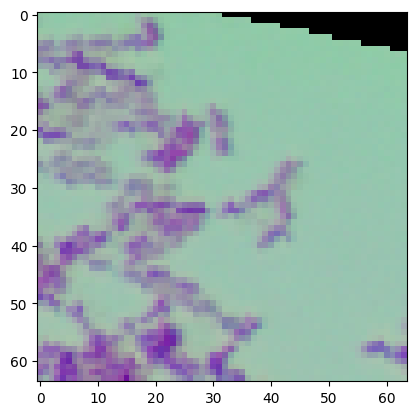

In [5]:
# visualizing a sample from train loader
print(train_dataset)
train_iter = iter(train_loader)

batch_images, batch_labels = next(train_iter)
image, label = batch_images[0], batch_labels[0]
print(image.shape)
plt.imshow(image.permute(1,2,0))
plt.show()

Building the model

Remember, that CNN's have a typical architecture that involve CONV -> Maxpool -> .... -> FC -> ... Output

https://pytorch.org/docs/stable/index.html

In [6]:

#This is a class module for to create a CNN, not the Module class in pytorch
#Is the base class for all models in pytorch, this contains the inner working of a module

#Functions ->
# The def __init__(self) is a constructor, where you outline the different layers and aspects of your custom class
# def forward is the function for forward propogationm you give it an input X and it outputs tensore

#Layers ->
#In pytorch a nn.Conv2d layer is a convolution 2d layer, the arguments are as follows
#nn.Conv2d(Number of Input features maps, Number of features maps, Kernel Size, Stride Size, Padding Size )
#nn.BatchNorm2d is a batch normalization layer that takes in a 2d tensor the argument is the number of input feature maps
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # First convolutional layer
        # Here we're defining a standard layer with Convolution, BatchNorm, and dropout
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=2)  # b x 3 x 32 x 32 -> b x 32 x 16 x 16
        self.batchnorm1 = nn.BatchNorm2d(32)                               # (channel x height x width), b is batch size
        self.relu1 = nn.ReLU()  # Using ReLU activation function
        self.dropout1 = nn.Dropout(0.1)  # Adding dropout to prevent overfitting

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2)  # b x 32 x 16 x 16 -> b x 64 x 8 x 8
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)  # Adding a pooling layer to reduce spatial dimensions, b x 64 x 8 x 8 -> b x 64 x 4 x 4
        self.dropout2 = nn.Dropout(0.05)

        # Third convolutional layer
        # self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # b x 64 x 4 x 4 -> b x 64 x 4 x 4
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=2)  # b x 64 x 4 x 4 -> b x 64 x 4 x 4
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.05)
        self.flatten = nn.Flatten()  # b x 64 x 4 x 4 -> b x (64 * 4 * 4)

        # Fully connected layer - classifying the features into 10 classes
        self.fc = nn.Linear(64 * 4 * 4, 128)  # 64 from the last conv layer, 10 for the number of classes, b x (64 * 4 * 4) -> b x 128
        # self.bachnorm4 = nn.BatchNorm1d(128)
        self.relu4 =  nn.ReLU()
        self.dropout4 = nn.Dropout(0.05)

        # self.fc0 = nn.Linear(128, 64)
        # self.relu5 =  nn.ReLU()
        self.fc1 = nn.Linear(128, 33)  # b x 128 -> b x 10

    def forward(self, x):
        # Describing the forward pass through the network
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.flatten(x)  # Flattening the output of the conv layers for the fully connected layer
        x = self.fc(x)
        # x = self.bachnorm4(x)
        x = self.relu4(x)
        # x = self.dropout4(x)

        # x = self.fc0(x)
        # x = self.relu5(x)
        x = self.fc1(x)
        return x  # The softmax (or another activation) can be implicitly applied by the loss function


In [7]:
# We are creating an instance of our CNN model, after which we load to model to
# the device either GPU or CPU
model = CNN()

model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.05, inplace=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.05, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1024, out_features=128, bias=True)
  (relu4): ReLU()
  (dropout4): Dropout(p=0.05, inplace=False)
  (fc1): Linear(in_features=128,

In [8]:
#This is where we define our loss, in this case the loss is cross entorpy
criterion = nn.CrossEntropyLoss()

In [9]:
#We define the optimizer here, the model.paramters() ar all the paramters of our model, lr is the learning rate
# optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-5)

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=1e-6, total_iters=50)

## Training


In [10]:
#This is the training loop, it will take the model, train loader, the optimizer and device
#It loops through each training data and trains the model
#Note the data is loaded in batches not single instances, this is important
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    for i, batch in tqdm(enumerate(train_loader)):  # looping through
        inputs, labels = batch # The bacth contains the inputs and labels
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)#
        loss = criterion(outputs, labels) # Error is calculated here, by the criterion(ie cross entropy loss)
        loss.backward()  # Computes the gradients and stores it in the model parameters' .grad attribute (this is backprop! or autodiff)
        optimizer.step() # Updates the weights to their new value(gradient update)
        optimizer.zero_grad()# Zeros out the gradients for next iteration
    print('End of epoch loss:', round(loss.item(), 3))

## Testing


In [11]:
accuracy_array = []

read_in_array_sources = np.loadtxt("./app/database_sources.txt", dtype="str", delimiter=":")
classes = read_in_array_sources[:,0]

#This is the same as above except that there is no optimization just testing for accruacy
def test(model, test_loader, device):
    # we've manually specified the classes - these are from the cifar-10 dataset

    # what is the first thing to do before testing?
    model.eval()
    correct = 0
    for i, batch in tqdm(enumerate(test_loader)):
         inputs, labels = batch
         inputs = inputs.to(device)
         labels = labels.to(device)
         outputs = model(inputs)
         predictions = outputs.argmax(dim=1)  # We take the maximum of the predictions, we take the max probability
         correct += (predictions == labels).sum().item()

    accuracy = 100 * correct / len(test_dataset)
    print(f"End of epoch accuracy: {accuracy}%")

    global accuracy_array
    accuracy_array= np.append(accuracy_array, accuracy)

    # visualizing the current model's performance
    # for i in range(min(len(inputs), 8)):
    #     print('Guess:', classes[predictions[i]], '| Label:', classes[labels[i]])
    #     plt.imshow(inputs[i].cpu().permute(1,2,0))
    #     plt.show()



```
# This is formatted as code
```

# Running the train-test loop

In [12]:
#This is where the training and testing loop is called
NUM_EPOCHS = 100 # One epoch is one loop through the training data

for epoch in range(NUM_EPOCHS):
    print("Epoch: ", epoch + 1)
    train_one_epoch(model, train_loader, optimizer, criterion, device)
    test(model, test_loader, device)

Epoch:  1


0it [00:00, ?it/s]

End of epoch loss: 3.295


0it [00:00, ?it/s]

In [ ]:
size = 0
for param in model.parameters():
    size += np.prod(param.shape)
print(f"Number of parameters: {size}")

In [ ]:
plt.plot(range(len(accuracy_array)), accuracy_array)

## Saving the weights

In [ ]:
# TODO: save the weights of your model (5 min) hint: look at the documentation or slides :))

torch.save(model.state_dict(), "model2.pth")

In [ ]:
# power outage!
# you've lost all your weights.
# or have you?
# TODO: reload the weights you just (hopefully) saved (5 min)

model_new = CNN()
model_new.load_state_dict(torch.load("model2.pth"))
model_new.to(device)
model_new.eval()

In [ ]:
test(model_new, test_loader, device)

Downloading Trained Parameters

In [ ]:
!wget https://github.com/LiyuZer/model_weights/raw/main/model.pth

In [ ]:
model_new = CNN()
model_new.load_state_dict(torch.load("model.pth.1"))
model_new.to(device)
model_new.eval()

In [ ]:
test(model_new, test_loader, device)

## **Congrats! You've just implemented a CNN from the ground up.**
## **If you want to go above and beyond, you can incorporate some of the following topics into your CNN model:**


*   Regularization (L2-regularization and dropout layers)
*   Transfer learning: https://pytorch.org/docs/stable/hub.html

